In [1]:
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
#from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import IPython.display as ipd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchaudio.functional import DB_to_amplitude

Importing augmentations

In [2]:
import augmentations

Setting config variables

In [3]:
MAX_LEN = 22000

In [4]:
df = pd.DataFrame(columns=['path', 'label', 'aug'])
# directory is bird_audio, subdirectories are the bird species, they have ogg files

# get the path of the audio files

import os
directory = 'bird_audio'
for subdir, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.ogg'):
            path = os.path.join(subdir, file)
            label = path.split('\\')[1]
            df = df._append({'path': path, 'label': label, "aug": None}, ignore_index=True)

In [5]:
df
# aug = [None, 'time-shift' 'noise', 'rotation', 'custom1']

path    label   aug
0       bird_audio\asbfly\XC134896.ogg   asbfly  None
1       bird_audio\asbfly\XC164848.ogg   asbfly  None
2       bird_audio\asbfly\XC175797.ogg   asbfly  None
3       bird_audio\asbfly\XC207738.ogg   asbfly  None
4       bird_audio\asbfly\XC209218.ogg   asbfly  None
...                                ...      ...   ...
24454  bird_audio\zitcis1\XC845747.ogg  zitcis1  None
24455  bird_audio\zitcis1\XC845817.ogg  zitcis1  None
24456  bird_audio\zitcis1\XC856176.ogg  zitcis1  None
24457  bird_audio\zitcis1\XC856723.ogg  zitcis1  None
24458  bird_audio\zitcis1\XC858550.ogg  zitcis1  None

[24459 rows x 3 columns]

Remember to only use augmentations for train and not for test

In [6]:
df.describe()

path    label  aug
count                            24459    24459    0
unique                           24459      182    0
top     bird_audio\asbfly\XC134896.ogg  zitcis1  NaN
freq                                 1      500  NaN

In [7]:
torchaudio.load(df['path'][0]) # sig, sr

(tensor([[ 1.3738e-06,  9.2571e-07, -2.7169e-06,  ...,  6.2166e-06,
          -1.4831e-06, -3.4762e-06]]),
 32000)

In [8]:
torchaudio.load(df['path'][0])[0].shape

torch.Size([1, 875207])

In [9]:
aud, sr = torchaudio.load(r"C:\Users\Arnav\Documents\Python Scripts\audioaugbtp\bird_audio\ruftre2\XC42639.ogg")
spectro = transforms.MelSpectrogram()(aud)
spectro = transforms.AmplitudeToDB()(spectro)

c:\Users\Arnav\anaconda3\envs\torchenv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [10]:
spectro.shape

torch.Size([1, 128, 6433])

In [11]:
matrix = spectro.numpy()[0]


In [12]:
# remove bottom 15 rows of spectrogram spectro, NOT matrix

spectro2 = spectro[:, 15:]
matrix2 = spectro2.numpy()[0]


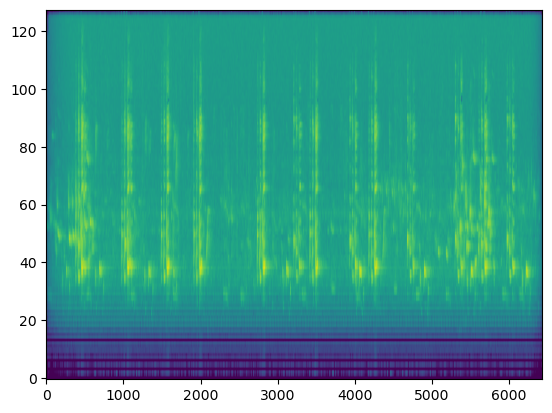

In [13]:
plt.imshow(matrix, aspect='auto', origin='lower')


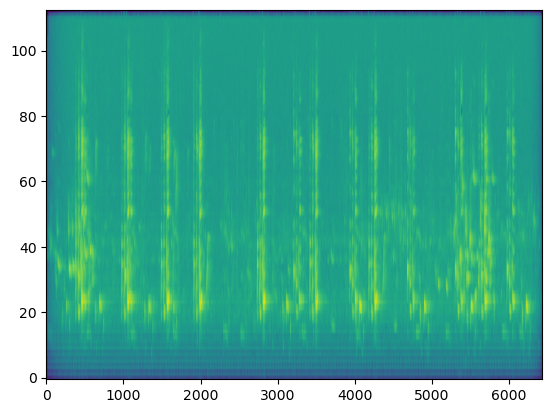

In [14]:
plt.imshow(matrix2, aspect='auto', origin='lower')

In [15]:
# hear the matrix by converting back to audio
n_fft = 1024
n_stft = int((n_fft//2)+1)
audn = DB_to_amplitude(spectro, ref=1.0, power=1)
audn = transforms.InverseMelScale(n_stft=n_stft)(audn)
audn = transforms.GriffinLim(n_fft=n_fft)(audn)
audn = audn.squeeze().numpy()
ipd.Audio(audn, rate=sr)

In [ ]:
class AugmentedTrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.length = df.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        path = self.df['path'][idx]
        label = self.df['label'][idx]
        #label = torch.tensor(label, dtype=torch.long)
        aud, sr = torchaudio.load(path)
        #do time domain stuff
        
        aud, sr = augmentations.pad_trunc((aud, sr), MAX_LEN)
        

        spectro = transforms.MelSpectrogram()(aud)
        spectro = transforms.AmplitudeToDB()(spectro)
        #remove bottom 15 rows of the matrix
        spectro = spectro[:,15:]
        spectro_m, spectro_s = spectro.mean(), spectro.std()
        spectro = torch.clamp(spectro, min=-40)
        spectro = (spectro - spectro_m) / spectro_s
        #do frequency domain stuff
        

        return spectro, label

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.length = df.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):

        path = self.df['path'][idx]
        label = self.df['label'][idx]
        label = torch.tensor(label, dtype=torch.long)
        aud, sr = torchaudio.load(path)
        #DO NOT AUGMENT, ONLY NORMALIZE (and other things like pad, trunc if needed)
        #do time domain stuff
        aud, sr = augmentations.pad_trunc((aud, sr), MAX_LEN)
        

        spectro = transforms.MelSpectrogram()(aud)
        spectro = transforms.AmplitudeToDB()(spectro)
        spectro = spectro[:, 15:]
        spectro_m, spectro_s = spectro.mean(), spectro.std()
        spectro = torch.clamp(spectro, min=-40)
        spectro = (spectro - spectro_m) / spectro_s
        
        #do frequency domain stuff
        

        return spectro, label

In [ ]:
model_df = df[df["label"].isin(['copbar1', "eurcoo"])]
labels = model_df['label'].unique()
label_map = {label: i for i, label in enumerate(labels)}
model_df["label"] = model_df["label"].map(label_map)

C:\Users\Arnav\AppData\Local\Temp\ipykernel_6752\3689911912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df["label"] = model_df["label"].map(label_map)


In [ ]:
model_df["label"].value_counts()

label
1    500
0    124
Name: count, dtype: int64

In [ ]:
# equalize the number of samples in the labels of the model_df
min_samples = model_df["label"].value_counts().min()
model_df = model_df.groupby("label").apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

C:\Users\Arnav\AppData\Local\Temp\ipykernel_6752\800467558.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_df = model_df.groupby("label").apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


In [ ]:
model_df["label"].value_counts()

label
0    124
1    124
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.2)

train_dataset = AugmentedTrainDataset(train_df.reset_index(drop=True))
test_dataset = AugmentedTrainDataset(test_df.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

tensor(0)


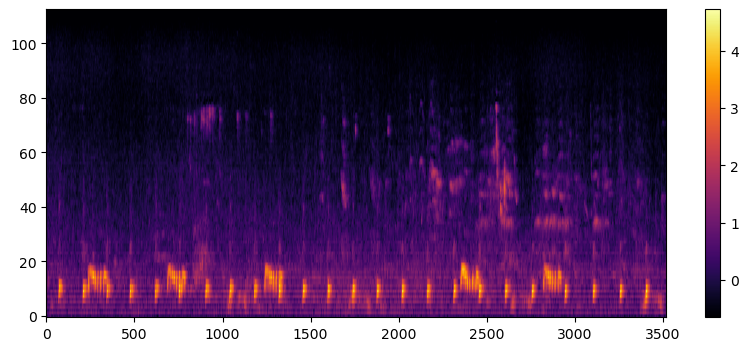

In [ ]:
exampleplot = next(iter(train_loader))
plt.figure(figsize=(10, 4))
plt.imshow(exampleplot[0][0][0].numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar()
print(exampleplot[1][0])

In [ ]:
class IDModel(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.ap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.lin1 = nn.Linear(64, 32)
        self.lin2 = nn.Linear(32, 64)
        self.lin3 = nn.Linear(64, len(label_map))

        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):

        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)

        return x

In [ ]:
myModel = IDModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

In [ ]:
def test(model, test_dl):
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for data in test_dl:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        acc = correct_preds / total_preds
        return acc

losslist = []
def training(model, train_dl, numepochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=numepochs,
                                                anneal_strategy='linear')
    for epoch in range(numepochs):
        runningloss = 0.0
        correct_preds = 0
        total_preds = 0

        for i, data in enumerate(train_dl):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            runningloss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            print(f"Batch: {i}, Loss: {loss.item()}")
            losslist.append(loss.item())
            
        
        num_batches = len(train_dl)
        avg_loss = runningloss / num_batches
        acc = correct_preds / total_preds
        test_acc = test(model, test_loader)
        print(f"Epoch: {epoch}, Loss: {avg_loss}, Accuracy: {acc}, Test Accuracy: {test_acc}")
    
    print("Finished Training")

In [ ]:
train_df["label"].value_counts()

In [ ]:
losslist = []
training(myModel, train_loader, 20)